## 1. Import Libraries

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## 2. Load and Inspect Dataset

In [26]:
df = pd.read_csv('../data/bank-full.csv', delimiter=';')

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 3. Drop Unnecessary Columns

In [27]:
df = df.drop(["day", "default", "education", "job", "marital", "loan"], axis=1)

## 4. Column Categorization Function

In [28]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

## 5. Replace Unknowns and Value Counts

In [29]:
for col in cat_cols:
    df[col] = df[col].apply(lambda x: x.replace('unknown', 'others'))

for col in cat_cols:
    if col != 'y':
        print(round(df.groupby([col]).agg({'y':'count'}).sort_values("y", ascending=False)/len(df), 3))

for col in num_cols:
    print(df[col].value_counts().head())

             y
housing       
yes      0.556
no       0.444
               y
contact         
cellular   0.648
others     0.288
telephone  0.064
           y
month       
may    0.304
jul    0.153
aug    0.138
jun    0.118
nov    0.088
apr    0.065
feb    0.059
jan    0.031
oct    0.016
sep    0.013
mar    0.011
dec    0.005
              y
poutcome       
others    0.817
failure   0.108
other     0.041
success   0.033
age
32    2085
31    1996
33    1972
34    1930
35    1894
Name: count, dtype: int64
balance
0    3514
1     195
2     156
4     139
3     134
Name: count, dtype: int64
duration
124    188
90     184
89     177
104    175
122    175
Name: count, dtype: int64
campaign
1    17544
2    12505
3     5521
4     3522
5     1764
Name: count, dtype: int64
pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
Name: count, dtype: int64
previous
0    36954
1     2772
2     2106
3     1142
4      714
Name: count, dtype: int64


## 6. Categorical Plots

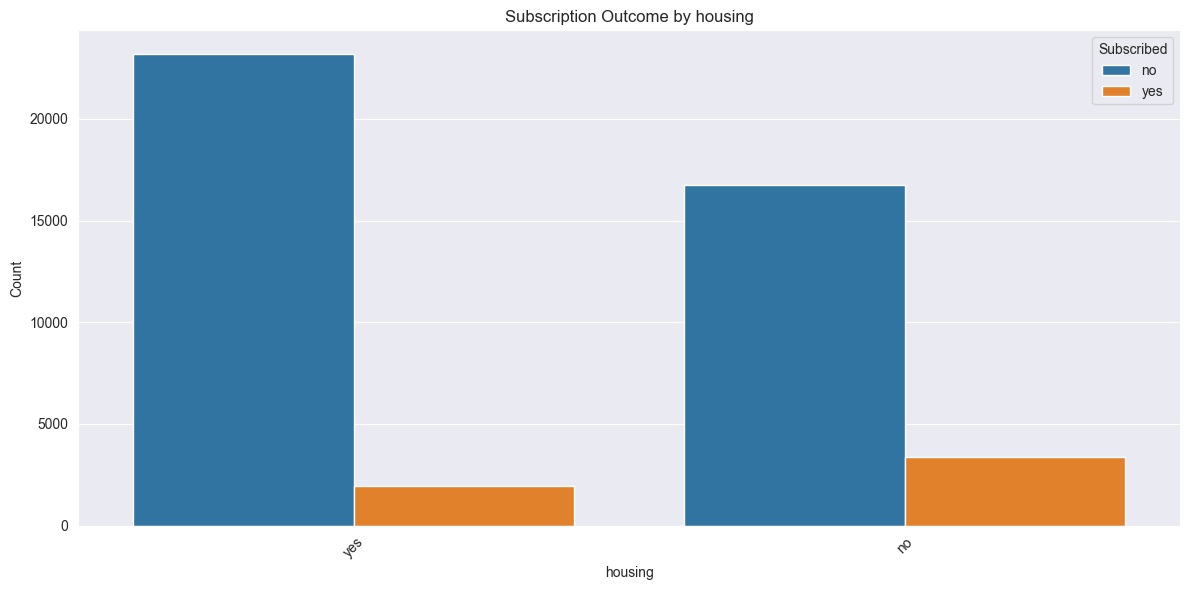

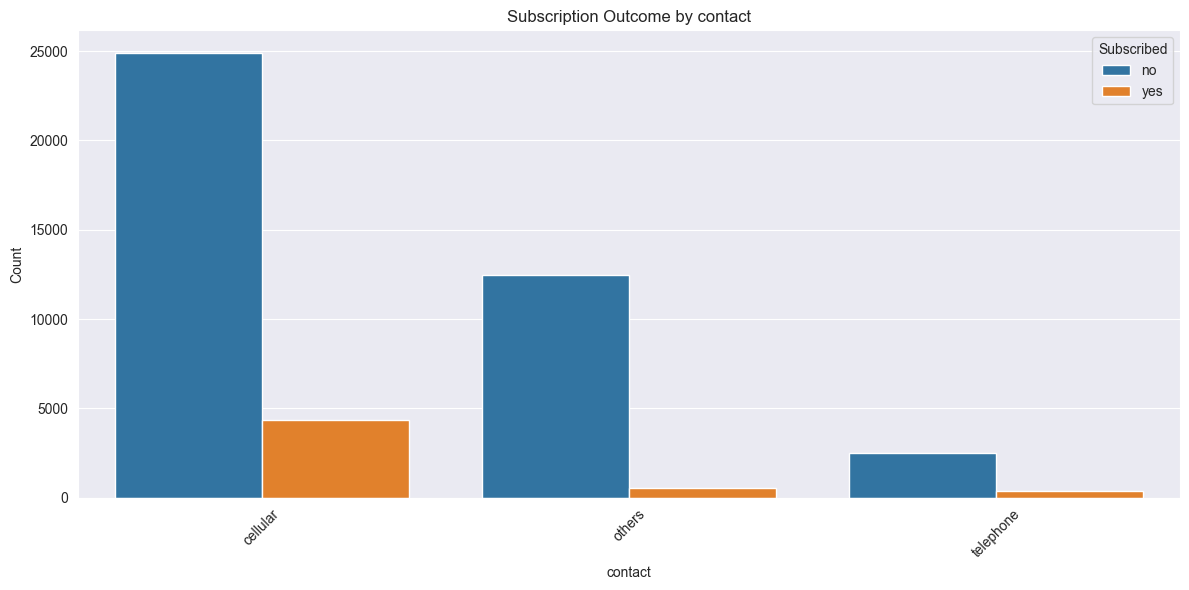

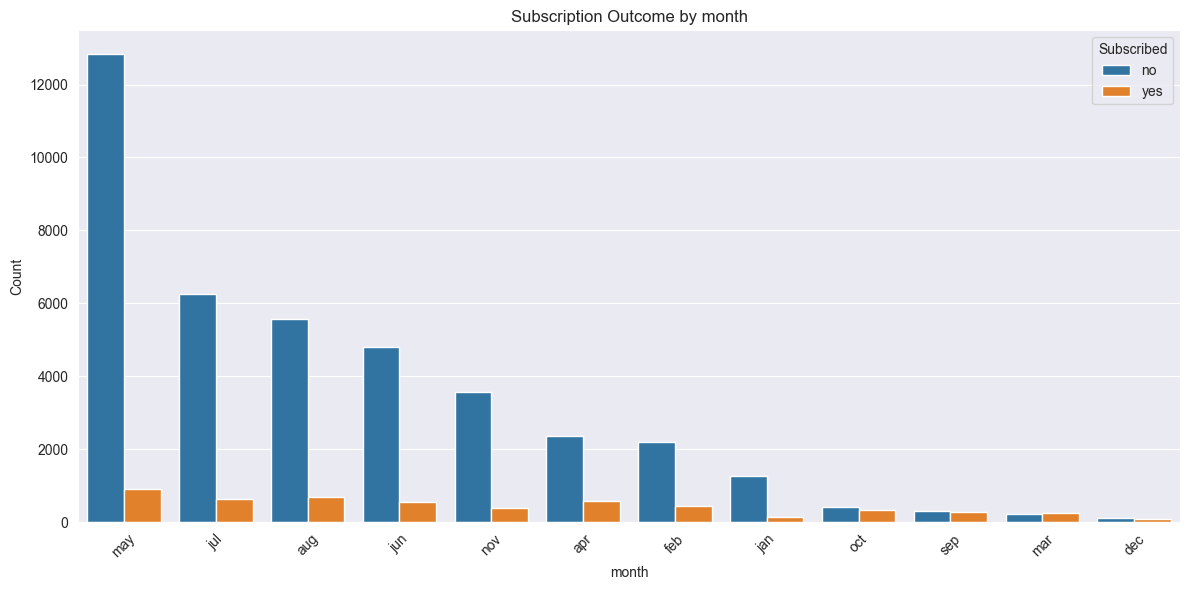

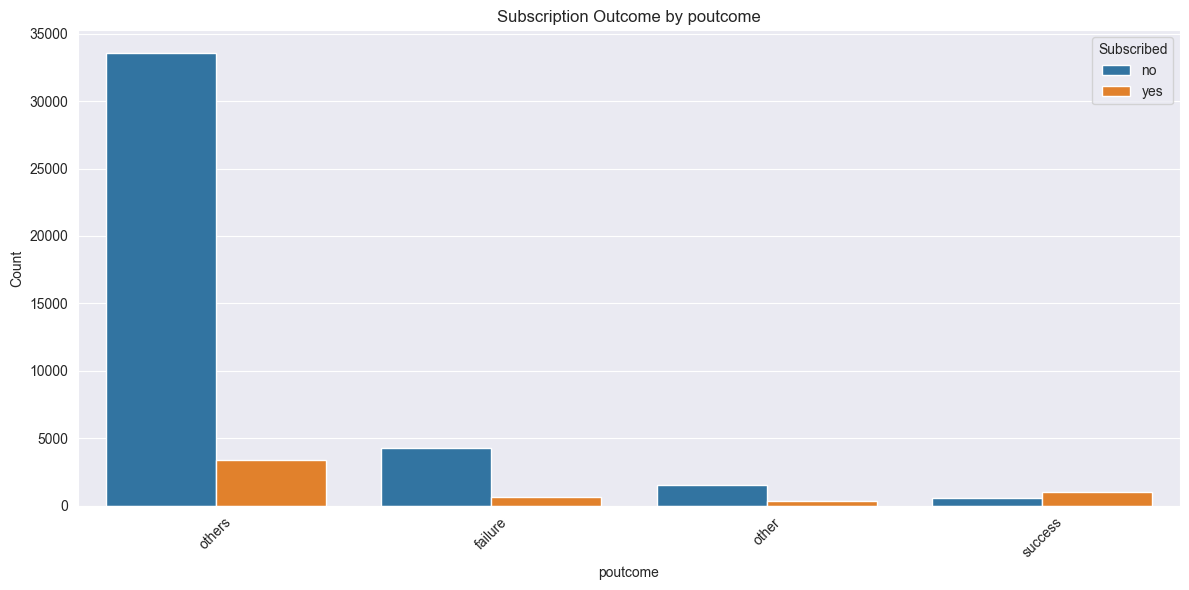

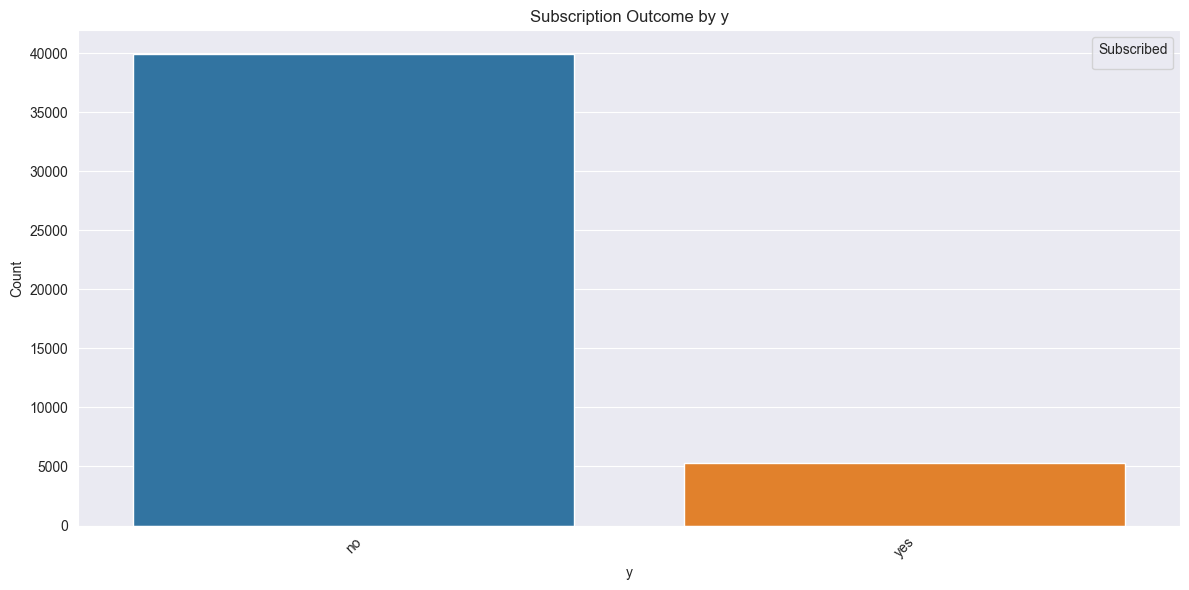

In [30]:
def cat_plot(dataframe, col):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x=col, hue='y', order=df[col].value_counts().index)

    plt.title(f'Subscription Outcome by {col}')
    plt.xlabel(f'{col}')
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Subscribed")
    plt.tight_layout()
    plt.show()

for col in cat_cols:
    cat_plot(df, col)

## 7. Numerical Plots

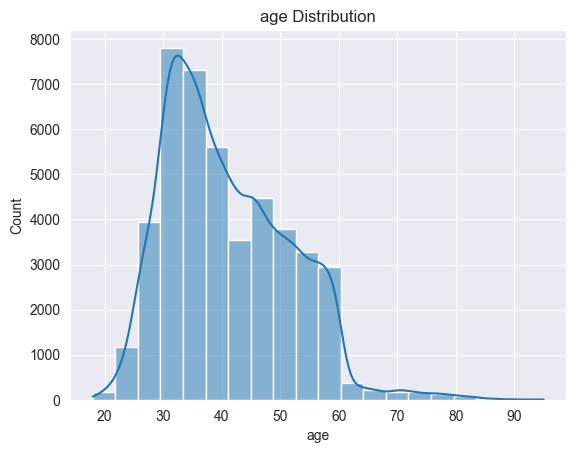

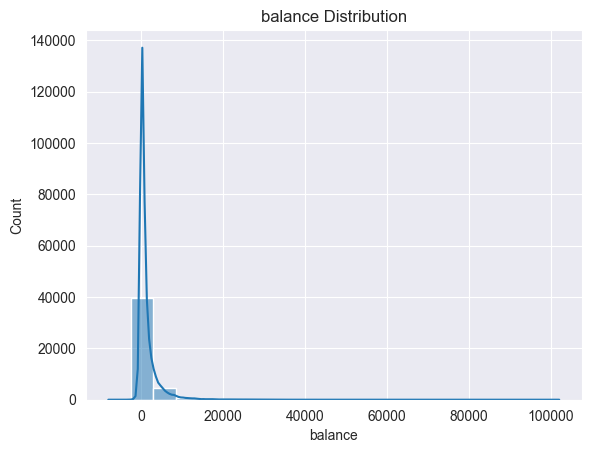

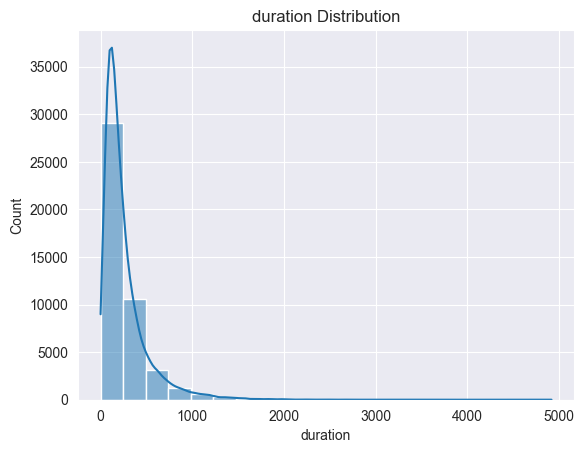

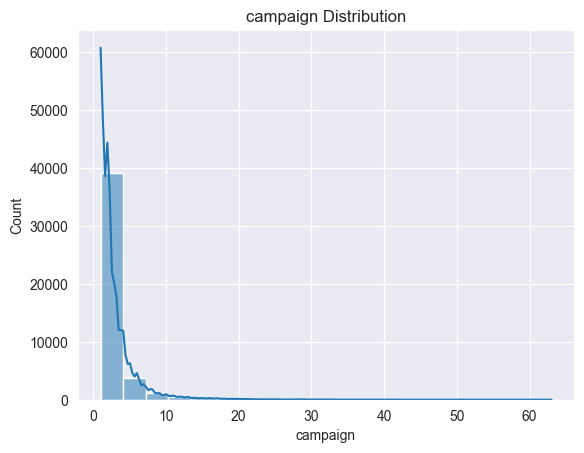

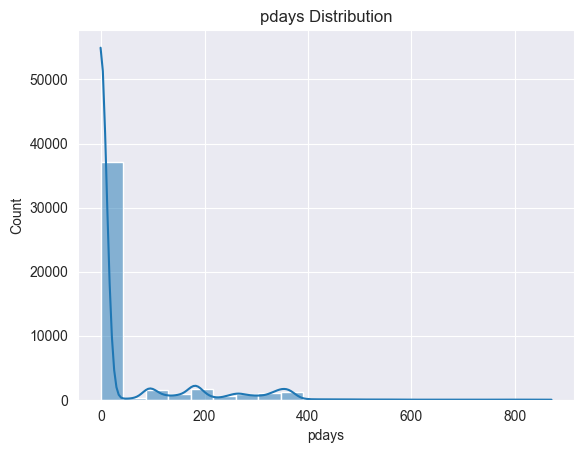

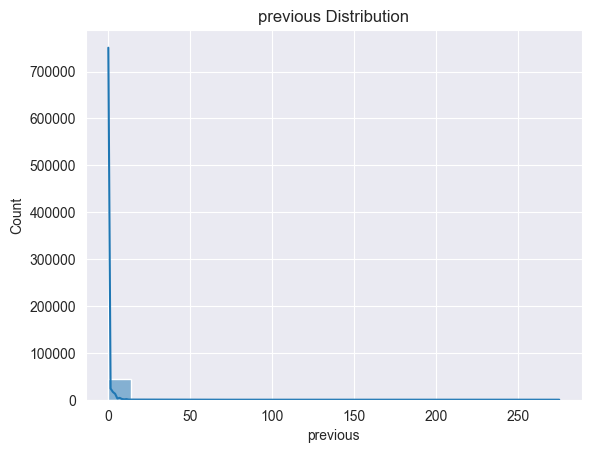

In [31]:
def num_plot(dataframe, col):
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'{col} Distribution')
    plt.show()

for col in num_cols:
    num_plot(df, col)

## 8. Label Encoding

In [32]:
le = LabelEncoder()
df = df.apply(le.fit_transform)

y = df["y"]
X = df.drop(["y"], axis=1)


import optuna

## 9. Train-Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Class Imbalance için scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# 6. Hyperparametre Optimizasyonu – CatBoost

## 10. CatBoost Hyperparameter Optimization

In [34]:
def objective_cb(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "verbose": False,
        "class_weights": {0: 1, 1: scale_pos_weight}
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, preds)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=20)
best_cb = CatBoostClassifier(**study_cb.best_params, verbose=False)
best_cb.fit(X_train, y_train)

# 7. Hyperparametre Optimizasyonu – XGBoost

[I 2025-06-24 22:40:49,136] A new study created in memory with name: no-name-dd872640-0856-454e-8a0e-8a55afd880bf
[I 2025-06-24 22:40:53,918] Trial 0 finished with value: 0.9210722964727106 and parameters: {'iterations': 288, 'learning_rate': 0.030864631157252898, 'depth': 5, 'l2_leaf_reg': 10}. Best is trial 0 with value: 0.9210722964727106.
[I 2025-06-24 22:40:58,123] Trial 1 finished with value: 0.9231105581945355 and parameters: {'iterations': 330, 'learning_rate': 0.08207251905379456, 'depth': 6, 'l2_leaf_reg': 1}. Best is trial 1 with value: 0.9231105581945355.
[I 2025-06-24 22:40:59,490] Trial 2 finished with value: 0.9006710952601344 and parameters: {'iterations': 335, 'learning_rate': 0.00757172235918151, 'depth': 4, 'l2_leaf_reg': 8}. Best is trial 1 with value: 0.9231105581945355.
[I 2025-06-24 22:41:00,950] Trial 3 finished with value: 0.9067443327695005 and parameters: {'iterations': 244, 'learning_rate': 0.006199358105719125, 'depth': 7, 'l2_leaf_reg': 4}. Best is trial 1

## 11. XGBoost Hyperparameter Optimization

In [35]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, preds)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=20)
best_xgb = XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

# 8. Hyperparametre Optimizasyonu – LightGBM

[I 2025-06-24 22:41:31,574] A new study created in memory with name: no-name-af41ef36-78e8-4bea-a452-cf6e2b848f0e
[I 2025-06-24 22:41:31,882] Trial 0 finished with value: 0.9014276532202983 and parameters: {'n_estimators': 282, 'learning_rate': 0.008989456915062007, 'max_depth': 3, 'subsample': 0.5455580233206274, 'colsample_bytree': 0.5422436515859295}. Best is trial 0 with value: 0.9014276532202983.
[I 2025-06-24 22:41:32,342] Trial 1 finished with value: 0.903453131047936 and parameters: {'n_estimators': 294, 'learning_rate': 0.002217355864957903, 'max_depth': 5, 'subsample': 0.619934120808926, 'colsample_bytree': 0.8716401203876983}. Best is trial 1 with value: 0.903453131047936.
[I 2025-06-24 22:41:33,009] Trial 2 finished with value: 0.9116479031454299 and parameters: {'n_estimators': 180, 'learning_rate': 0.0019376117759081352, 'max_depth': 9, 'subsample': 0.9810846162324692, 'colsample_bytree': 0.9234451841288911}. Best is trial 2 with value: 0.9116479031454299.
[I 2025-06-24 2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5009535785680728, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.019528614731967122,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=452, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 12. LightGBM Hyperparameter Optimization

In [46]:
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1),  # updated
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "class_weight": {0: 1, 1: scale_pos_weight},
        "verbosity": -1
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, preds)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=20)

best_lgb = LGBMClassifier(**study_lgb.best_params)
best_lgb.fit(X_train, y_train)



[I 2025-06-24 22:51:42,945] A new study created in memory with name: no-name-7008ecfa-de64-4a74-956d-e25dd0f93597
[I 2025-06-24 22:51:44,906] Trial 0 finished with value: 0.9230350385233181 and parameters: {'n_estimators': 255, 'learning_rate': 0.05312406734987056, 'max_depth': 6, 'num_leaves': 29}. Best is trial 0 with value: 0.9230350385233181.
[I 2025-06-24 22:51:47,362] Trial 1 finished with value: 0.9112294081648837 and parameters: {'n_estimators': 172, 'learning_rate': 0.00813995367467037, 'max_depth': 7, 'num_leaves': 62}. Best is trial 0 with value: 0.9230350385233181.
[I 2025-06-24 22:51:50,640] Trial 2 finished with value: 0.9235587638921275 and parameters: {'n_estimators': 440, 'learning_rate': 0.018200627208735495, 'max_depth': 10, 'num_leaves': 46}. Best is trial 2 with value: 0.9235587638921275.
[I 2025-06-24 22:51:52,317] Trial 3 finished with value: 0.9199923533373657 and parameters: {'n_estimators': 177, 'learning_rate': 0.019062390631672258, 'max_depth': 7, 'num_leave

LGBMClassifier(learning_rate=0.05518007231717046, max_depth=9, n_estimators=205,
               num_leaves=20)

## 13. Feature Selection with CatBoost

In [47]:
importances = pd.Series(best_cb.get_feature_importance(), index=X_train.columns)
threshold = np.percentile(importances, 20)
selected = importances[importances > threshold].index
X_train_sel = X_train[selected]
X_test_sel  = X_test[selected]


## 14. Ensemble Model with VotingClassifier

In [48]:
voting = VotingClassifier(
    estimators=[("cb", best_cb), ("xgb", best_xgb), ("lgb", best_lgb)],
    voting="soft",
    n_jobs=-1
)
voting.fit(X_train_sel, y_train)


/Users/omercancelik/Desktop/ML&AI/Bootcamp/PythonProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x310e83c40>),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5009535785680728,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=Non...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=452, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.05518007231717046,
                                             max_depth=9, n_estimators=205,
                                             num_leaves=20))],
                 n_jobs=-1, voting='soft')

## 15. Threshold Optimization and Evaluation

In [49]:
probs = voting.predict_proba(X_test_sel)[:,1]
prec, rec, thr = precision_recall_curve(y_test, probs)
f1_scores = 2 * prec * rec / (prec + rec)
best_idx = np.nanargmax(f1_scores)
best_thr = thr[best_idx]
y_pred = (probs >= best_thr).astype(int)

# 12. Son Değerlendirme

## 16. Final Classification Report

In [50]:
print(f"=== Ensemble Değerlendirme (Threshold: {best_thr:.3f}) ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, probs))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

=== Ensemble Değerlendirme (Threshold: 0.273) ===
Accuracy : 0.8958310295255999
ROC AUC  : 0.9256859210263098

Classification Report:
              precision    recall  f1-score   support

           0     0.9615    0.9188    0.9397      7985
           1     0.5411    0.7221    0.6186      1058

    accuracy                         0.8958      9043
   macro avg     0.7513    0.8205    0.7792      9043
weighted avg     0.9123    0.8958    0.9021      9043

